In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
FOLDERNAME = 'DP/data/'
if FOLDERNAME is None: FOLDERNAME = input("[!] Enter folder name: ")

os.chdir(f'/content/drive/MyDrive/Colab Notebooks/{FOLDERNAME}')

Mounted at /content/drive


# Base model

In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import math

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
!pip install torchinfo

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchinfo import summary

In [5]:
os.listdir()

['VS-1-30',
 'crossmoda2022_training',
 'VS-31-61',
 'VS-62-91',
 'VS-92-112',
 'VS-113-143',
 'VS-239-250',
 'all_structures',
 'VS-144-175',
 'VS-176-205',
 'VS-206-238',
 'training_outputs']

In [6]:
t1_list = sorted(glob.glob('VS-*/vs_*/*_t1_*'))
t2_list = sorted(glob.glob('VS-*/vs_*/*_t2_*'))
seg_list = sorted(glob.glob('VS-*/vs_*/*_seg_*'))

In [7]:
print(len(t1_list), len(t2_list), len(seg_list))

print(t1_list[:10])
print(t2_list[:10])
print(seg_list[:10])

252 252 252
['VS-1-30/vs_gk_1/vs_gk_t1_refT2.nii.gz', 'VS-1-30/vs_gk_10/vs_gk_t1_refT2.nii.gz', 'VS-1-30/vs_gk_11/vs_gk_t1_refT2.nii.gz', 'VS-1-30/vs_gk_12/vs_gk_t1_refT2.nii.gz', 'VS-1-30/vs_gk_13/vs_gk_t1_refT2.nii.gz', 'VS-1-30/vs_gk_14/vs_gk_t1_refT2.nii.gz', 'VS-1-30/vs_gk_15/vs_gk_t1_refT2.nii.gz', 'VS-1-30/vs_gk_16/vs_gk_t1_refT2.nii.gz', 'VS-1-30/vs_gk_17/vs_gk_t1_refT2.nii.gz', 'VS-1-30/vs_gk_18/vs_gk_t1_refT2.nii.gz']
['VS-1-30/vs_gk_1/vs_gk_t2_refT2.nii.gz', 'VS-1-30/vs_gk_10/vs_gk_t2_refT2.nii.gz', 'VS-1-30/vs_gk_11/vs_gk_t2_refT2.nii.gz', 'VS-1-30/vs_gk_12/vs_gk_t2_refT2.nii.gz', 'VS-1-30/vs_gk_13/vs_gk_t2_refT2.nii.gz', 'VS-1-30/vs_gk_14/vs_gk_t2_refT2.nii.gz', 'VS-1-30/vs_gk_15/vs_gk_t2_refT2.nii.gz', 'VS-1-30/vs_gk_16/vs_gk_t2_refT2.nii.gz', 'VS-1-30/vs_gk_17/vs_gk_t2_refT2.nii.gz', 'VS-1-30/vs_gk_18/vs_gk_t2_refT2.nii.gz']
['VS-1-30/vs_gk_1/vs_gk_seg_refT2.nii.gz', 'VS-1-30/vs_gk_10/vs_gk_seg_refT2.nii.gz', 'VS-1-30/vs_gk_11/vs_gk_seg_refT2.nii.gz', 'VS-1-30/vs_gk_12/v

In [8]:
t1_train, t1_val, t2_train, t2_val, seg_train, seg_val = train_test_split(t1_list, t2_list, seg_list, test_size=0.2, train_size=0.8, random_state=420)

In [9]:
print(len(t1_train), len(t2_train), len(seg_train))
print(len(t1_val), len(t2_val), len(seg_val))

print('t1_train:', t1_train[:3])
print('t2_train: ', t2_train[:3])
print('seg_train: ', seg_train[:3])
print()
print('t1_val: ', t1_val[:3])
print('t2_val', t2_val[:3])
print('seg_val', seg_val[:3])

201 201 201
51 51 51
t1_train: ['VS-62-91/vs_gk_87/vs_gk_t1_refT2.nii.gz', 'VS-144-175/vs_gk_164/vs_gk_t1_refT2.nii.gz', 'VS-92-112/vs_gk_118/vs_gk_t1_refT2.nii.gz']
t2_train:  ['VS-62-91/vs_gk_87/vs_gk_t2_refT2.nii.gz', 'VS-144-175/vs_gk_164/vs_gk_t2_refT2.nii.gz', 'VS-92-112/vs_gk_118/vs_gk_t2_refT2.nii.gz']
seg_train:  ['VS-62-91/vs_gk_87/vs_gk_seg_refT2.nii.gz', 'VS-144-175/vs_gk_164/vs_gk_seg_refT2.nii.gz', 'VS-92-112/vs_gk_118/vs_gk_seg_refT2.nii.gz']

t1_val:  ['VS-113-143/vs_gk_137/vs_gk_t1_refT2.nii.gz', 'VS-92-112/vs_gk_96/vs_gk_t1_refT2.nii.gz', 'VS-31-61/vs_gk_33/vs_gk_t1_refT2.nii.gz']
t2_val ['VS-113-143/vs_gk_137/vs_gk_t2_refT2.nii.gz', 'VS-92-112/vs_gk_96/vs_gk_t2_refT2.nii.gz', 'VS-31-61/vs_gk_33/vs_gk_t2_refT2.nii.gz']
seg_val ['VS-113-143/vs_gk_137/vs_gk_seg_refT2.nii.gz', 'VS-92-112/vs_gk_96/vs_gk_seg_refT2.nii.gz', 'VS-31-61/vs_gk_33/vs_gk_seg_refT2.nii.gz']


## Data generator

In [10]:
def get_glioma_indices(mask):
  first = torch.nonzero((mask == 1))[:,1][0].item()
  last = torch.nonzero((mask == 1))[:,1][-1].item()

  return first, last

In [11]:
# https://arxiv.org/abs/2011.01045
# https://github.com/lescientifik/open_brats2020/tree/main
def normalize(image):
    """ Basic min max scaler. """
    min_ = torch.min(image)
    max_ = torch.max(image)
    scale = max_ - min_
    image = (image - min_) / scale
    return image


def irm_min_max_preprocess(image, low_perc=1, high_perc=99):
    """Main pre-processing function used for the challenge (seems to work the best).

    Remove outliers voxels first, then min-max scale.

    Warnings
    --------
    This will not do it channel wise!!
    """

    non_zeros = image > 0
    low, high = torch.percentile(image[non_zeros], [low_perc, high_perc])
    image = torch.clip(image, low, high)
    image = normalize(image)
    return image

In [12]:
class MRIDataset(Dataset):
    def __init__(self, t1_list, t2_list, seg_list, img_dims):
        self.t1_list = t1_list
        self.t2_list = t2_list
        self.seg_list = seg_list
        self.img_dims = img_dims

    def __len__(self):
      return len(self.t1_list)

    def _get_glioma_indices(self, mask):
      first = torch.nonzero((mask == 1))[:,0][0].item()
      last = torch.nonzero((mask == 1))[:,0][-1].item()

      return first, last

    def _crop_depth(self, mask):
      first, last = self._get_glioma_indices(mask)
      range_length = last - first + 1

      # print(f'old indices: {first}, {last} : {first - last}')

      # compute the desired padding size on both sides
      padding_size = self.img_dims[0] - range_length
      padding_size_left = math.floor(padding_size / 2)
      padding_size_right = math.ceil(padding_size / 2)

      # compute the new start and end indices of the cropped depth dimension
      mid_index = (first + last) // 2
      start_index = max(mid_index - math.floor(self.img_dims[0] / 2), 0)
      end_index = min(start_index + self.img_dims[0], mask.shape[0])

      # crop the volume along the depth dimension
      # cropped_volume = volume[start_index:end_index,:,:]

      return start_index, end_index

    def _normalise(self, volume):
      # mean = torch.mean(volume, dim=(0, 1, 2), keepdim=True)
      # sd = torch.std(volume, dim=(0, 1, 2), keepdim=True)
      # return (volume - mean) / sd
      # return irm_min_max_preprocess(volume)
      return normalize(volume)

    def __getitem__(self, idx):
      t1 = torch.as_tensor(nib.load(self.t1_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
      t2 = torch.as_tensor(nib.load(self.t2_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
      seg = torch.as_tensor(nib.load(self.seg_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)

      # print('old shapes: ', t1.shape, t2.shape, seg.shape)

      t1 = TF.center_crop(t1, (self.img_dims[1]*2, self.img_dims[2]*2))
      t2 = TF.center_crop(t2, (self.img_dims[1]*2, self.img_dims[2]*2))
      seg = TF.center_crop(seg, (self.img_dims[1]*2, self.img_dims[2]*2))

      if t1.shape[0] > self.img_dims[0]:
        start_index, end_index = self._crop_depth(seg)
        t1 = t1[start_index:end_index,:,:]
        t2 = t2[start_index:end_index,:,:]
        seg = seg[start_index:end_index,:,:]
        # print(t1.shape[0], t2.shape[0], seg.shape[0])

        first, last = self._get_glioma_indices(seg)
        # print(f'new indices: {first}, {last} : {first - last}')

      elif t1.shape[0] < self.img_dims[0]:
        pad = (0, 0, 0, 0, (self.img_dims[0]-t1.shape[0])//2, (self.img_dims[0]-t1.shape[0])//2)
        t1 = F.pad(t1, pad, "constant", 0)
        t2 = F.pad(t2, pad, "constant", 0)
        seg = F.pad(seg, pad, "constant", 0)
        # print(t1.shape[0], t2.shape[0], seg.shape[0])

      t1 = TF.resize(t1, (self.img_dims[1], self.img_dims[2]), interpolation=TF.InterpolationMode.NEAREST, antialias=False)
      t2 = TF.resize(t2, (self.img_dims[1], self.img_dims[2]), interpolation=TF.InterpolationMode.NEAREST, antialias=False)
      seg = TF.resize(seg, (self.img_dims[1], self.img_dims[2]), interpolation=TF.InterpolationMode.NEAREST, antialias=False)

      t1 = self._normalise(t1)
      t2 = self._normalise(t2)

      stacked = torch.stack((t1, t2), axis=0)
      seg = seg.unsqueeze(0)

      return stacked, seg

In [13]:
combined_t1 = t1_train + t1_val
combined_t2 = t2_train + t2_val
combined_seg = seg_train + seg_val

print(len(combined_t1), len(combined_t2), len(combined_seg))

252 252 252


### Testing data generator

In [14]:
seg = torch.as_tensor(nib.load(combined_seg[0]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
seg.shape

torch.Size([80, 448, 448])

In [15]:
torch.unique(seg.unsqueeze(0)[0])

tensor([0., 1.])

#### 40x80x80

In [45]:
# transform = transforms.Compose([transforms.Resize((256, 256), antialias=False)])
data = MRIDataset([t1_train[0]], [t2_train[0]], [seg_train[0]], (40, 80, 80))

In [44]:
img, label = data[0]
print(img.shape, label.shape)
print(img.dtype, label.dtype)

torch.Size([2, 40, 80, 80]) torch.Size([1, 40, 80, 80])
torch.float32 torch.float32


Text(0.5, 1.0, 'Segmentation')

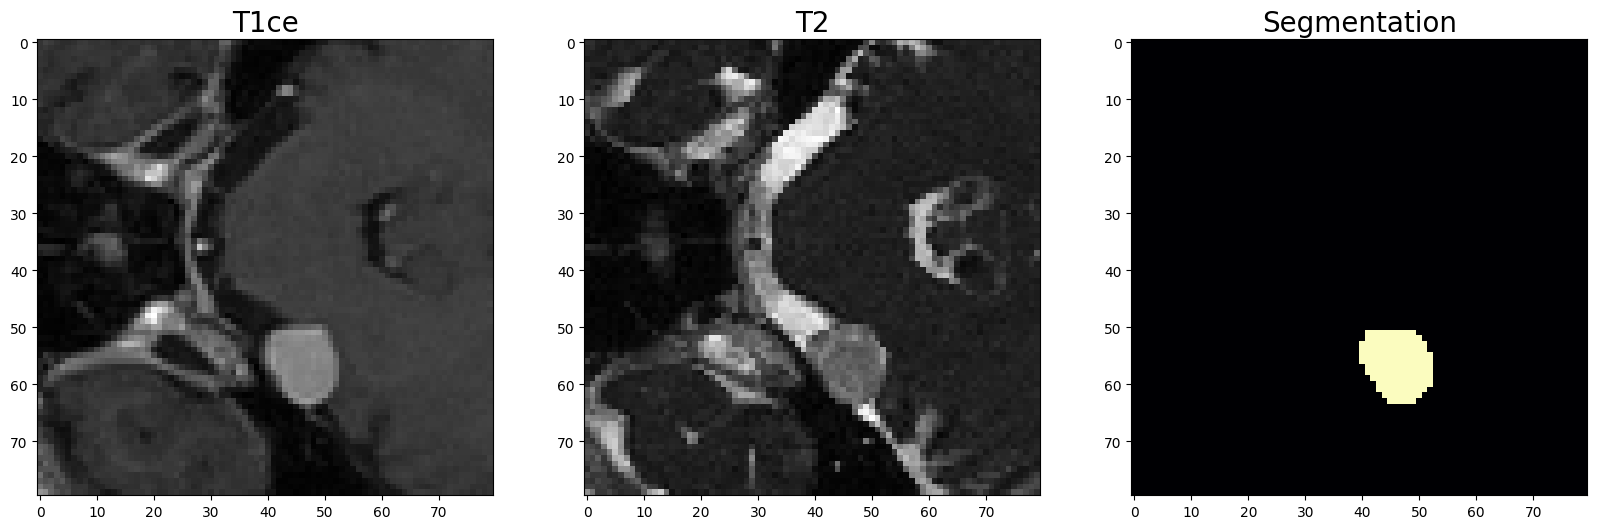

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
x, y = data[0]
axs[0].imshow(x[0,20,:,:], cmap='gray')
# axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[1,20,:,:], cmap='gray')
# axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,20,:,:], cmap='magma')
# axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)

#### 40x128x128

Text(0.5, 1.0, 'Segmentation')

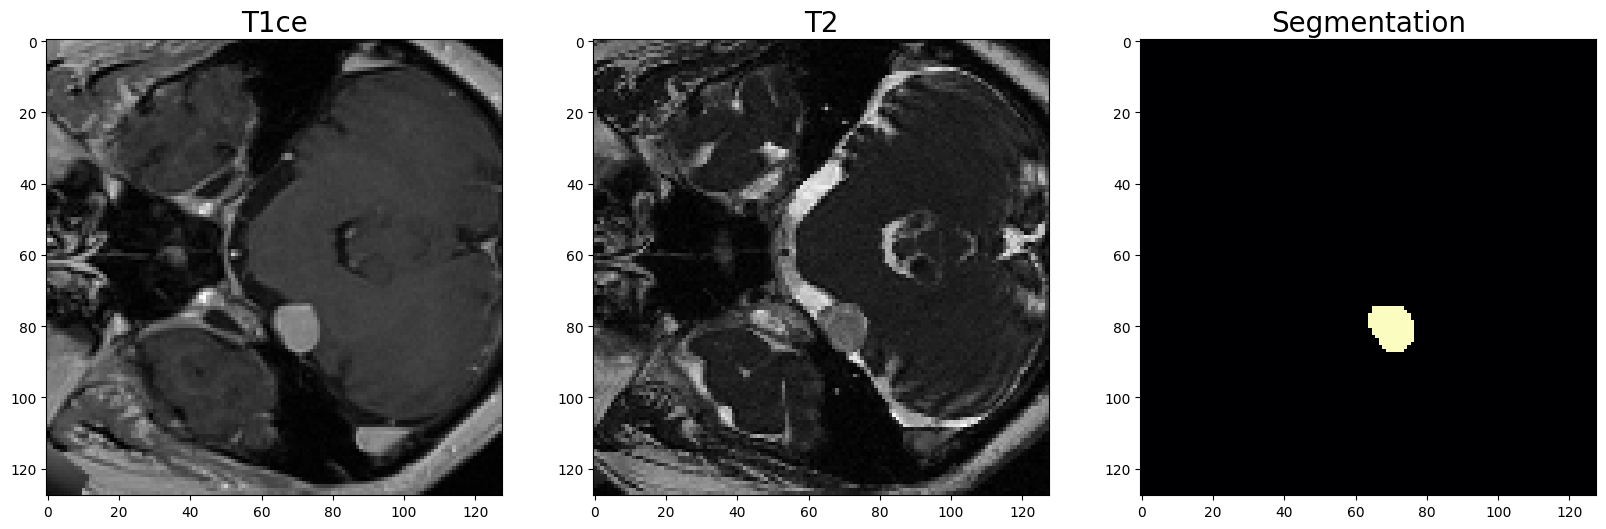

In [29]:
# transform = transforms.Compose([transforms.Resize((256, 256), antialias=False)])
data = MRIDataset([t1_train[0]], [t2_train[0]], [seg_train[0]], (40, 128, 128))

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
x, y = data[0]
axs[0].imshow(x[0,20,:,:], cmap='gray')
# axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[1,20,:,:], cmap='gray')
# axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,20,:,:], cmap='magma')
# axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)

#### 40x40x40

Text(0.5, 1.0, 'Segmentation')

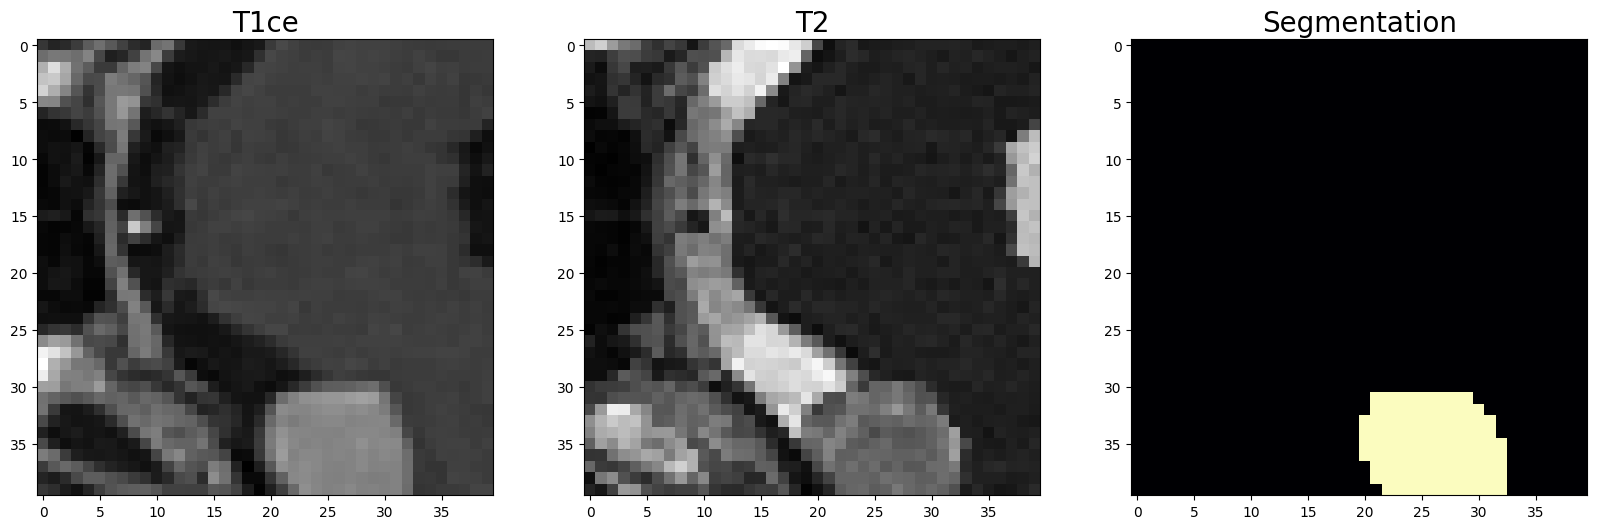

In [30]:
# transform = transforms.Compose([transforms.Resize((256, 256), antialias=False)])
data = MRIDataset([t1_train[0]], [t2_train[0]], [seg_train[0]], (40, 40, 40))

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
x, y = data[0]
axs[0].imshow(x[0,20,:,:], cmap='gray')
# axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[1,20,:,:], cmap='gray')
# axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,20,:,:], cmap='magma')
# axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)

### Class weights

In [19]:
def get_class_count(seg):
  labels, counts = torch.unique(seg[0], return_counts=True)
  print(counts)
  print((counts[1]/counts[0]).item())


#### 40x128x128

In [25]:
data = MRIDataset(combined_t1, combined_t2, combined_seg, (40, 128, 128))

In [ ]:
classes = {0: 0, 1: 0}
for i in range(len(data)):
  x, y = data[i]
  labels, counts = torch.unique(y[0], return_counts=True)
  classes[0] += counts[0].item()
  classes[1] += counts[1].item()
  print(i, classes)

In [22]:
# {0: 164753098, 1: 397622}
classes = {0: 164753098, 1: 397622}
classes[1] / classes[0]

0.0024134417187105035

In [ ]:
for i in range(len(data)):
  print('==========')
  print(f'scan: {i}')
  x, y = data[i]
  print('shapes: ', x[0].shape, x[1].shape, y[0].shape)
  get_class_count(y)

#### 40x80x80

In [ ]:
data = MRIDataset(combined_t1, combined_t2, combined_seg, (40, 80, 80))

In [ ]:
classes = {0: 0, 1: 0}
for i in range(len(data)):
  x, y = data[i]
  labels, counts = torch.unique(y[0], return_counts=True)
  classes[0] += counts[0].item()
  classes[1] += counts[1].item()
  print(i, classes)

In [27]:
# {0: 64115061, 1: 396939}
classes = {0: 64115061, 1: 396939}
print(classes[1] / classes[0])
print(classes[0] / classes[1])

0.006191041446564326
161.52371271152495


In [ ]:
for i in range(len(data)):
  print('==========')
  print(f'scan: {i}')
  x, y = data[i]
  print('shapes: ', x[0].shape, x[1].shape, y[0].shape)
  classes[0] +
  get_class_count(y)

### Union over masks

In [ ]:
data = MRIDataset(combined_t1, combined_t2, combined_seg, (40, 80, 80))

In [ ]:
masks_combined = torch.zeros((40, 80, 80))

In [ ]:
for i in range(len(data)):
  print(f'scan: {i}')
  _, y = data[i]
  masks_combined += y[0]

# i = 0
# for (_, mask) in data_gen:
#   mask = mask[0, :, :, :, 0]
#   masks_combined += mask
#   i += 1
#   if i%10==0: print(i)
# i

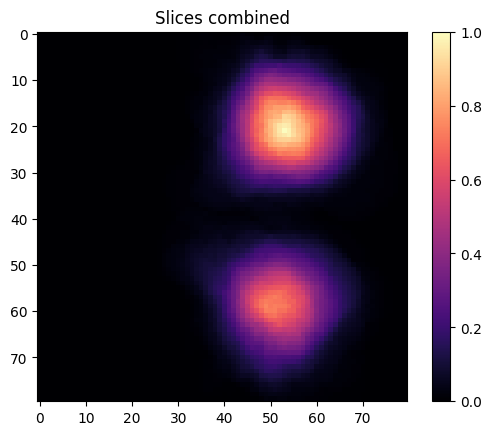

In [ ]:
summed = torch.sum(masks_combined, axis=0)
a = summed / summed.max()

plt.imshow(a, cmap='magma')
plt.title('Slices combined')
cb = plt.colorbar()
plt.show()

## Model

In [28]:
def build_conv_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv3d(in_channels[0], out_channels[0], kernel_size=3, padding=1, padding_mode='zeros'),
      nn.ReLU(),
      nn.Conv3d(in_channels[1], out_channels[1], kernel_size=3, padding=1, padding_mode='zeros'),
      nn.ReLU(),
      )


class DownBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = build_conv_block(in_channels=[in_channels[0], in_channels[1]], out_channels=[out_channels[0], out_channels[1]])
    self.down = nn.MaxPool3d(kernel_size=2)

  def forward(self, x):
    out = self.conv(x)
    downscaled = self.down(out)

    return out, downscaled

class UpBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose3d(in_channels=in_channels[0], out_channels=out_channels[0], kernel_size=2, stride=2)
    # self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
    self.conv = build_conv_block(in_channels=[in_channels[0], in_channels[1]], out_channels=[out_channels[1], out_channels[1]])

  def forward(self, x, skip):
    upscaled = self.up(x)
    # print(upscaled.shape, skip.shape)
    concat = torch.cat([skip, upscaled], dim=1)
    # print(concat.shape)
    out = self.conv(concat)
    # print(out.shape)

    # print()
    return out

class Unet(nn.Module):
  def __init__(self):
      super().__init__()
      self.down1 = DownBlock(in_channels=[2, 32], out_channels=[32, 32])
      self.down2 = DownBlock(in_channels=[32, 64], out_channels=[64, 64])
      self.down3 = DownBlock(in_channels=[64, 128], out_channels=[128, 128])
      # self.down4 = DownBlock(in_channels=[64, 128], out_channels=[128, 128])

      self.bottle_neck = build_conv_block(in_channels=[128, 256], out_channels=[256, 256])

      # self.up1 = UpBlock(in_channels=[256, 128], out_channels=[128, 128])
      self.up2 = UpBlock(in_channels=[256, 128], out_channels=[128, 128])
      self.up3 = UpBlock(in_channels=[128, 64], out_channels=[64, 64])
      self.up4 = UpBlock(in_channels=[64, 32], out_channels=[32, 32])

      self.output = nn.Sequential(
          nn.Conv3d(in_channels=32, out_channels=1, kernel_size=1),
          nn.Sigmoid()
      )

  def forward(self, x):
    # Contracting path
    skip1, down1 = self.down1(x)
    skip2, down2 = self.down2(down1)
    skip3, down3 = self.down3(down2)
    # skip4, down4 = self.down4(down3)

    # Bottle neck
    bottom = self.bottle_neck(down3)

    # Expanding path
    # up1 = self.up1(bottom, skip4)
    up2 = self.up2(bottom, skip3)
    up3 = self.up3(up2, skip2)
    up4 = self.up4(up3, skip1)

    # Output
    out = self.output(up4)

    return out

# model = Unet()
# model

In [ ]:
summary(Unet(), input_size=(2, 2, 40, 80, 80))

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [2, 1, 40, 80, 80]        --
├─DownBlock: 1-1                         [2, 32, 40, 80, 80]       --
│    └─Sequential: 2-1                   [2, 32, 40, 80, 80]       --
│    │    └─Conv3d: 3-1                  [2, 32, 40, 80, 80]       1,760
│    │    └─ReLU: 3-2                    [2, 32, 40, 80, 80]       --
│    │    └─Conv3d: 3-3                  [2, 32, 40, 80, 80]       27,680
│    │    └─ReLU: 3-4                    [2, 32, 40, 80, 80]       --
│    └─MaxPool3d: 2-2                    [2, 32, 20, 40, 40]       --
├─DownBlock: 1-2                         [2, 64, 20, 40, 40]       --
│    └─Sequential: 2-3                   [2, 64, 20, 40, 40]       --
│    │    └─Conv3d: 3-5                  [2, 64, 20, 40, 40]       55,360
│    │    └─ReLU: 3-6                    [2, 64, 20, 40, 40]       --
│    │    └─Conv3d: 3-7                  [2, 64, 20, 40, 40]       110,656

## Training

In [31]:
import IPython

In [32]:
config = {
    "lr": 1e-3,
    "num_classes": 1,
    "img_channels": 1, # 2
    "dataset": "Schwanoma",
    "epochs": 50,
    "batch_size": 4,
    "loss": "bce",
    "optimizer": "Adam",
    "augment": False,
    "scheduler": False,
}

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [34]:
def preview(y_pred, y, dice, epoch=0):
  first, last = get_glioma_indices(y)
  length = (last-first+1)
  n_graphs = length - (length%6)
  rows = n_graphs//6
  cols = 6

  fig, axs = plt.subplots(rows, cols, figsize=(18, 5))
  axs = axs.flatten()
  j = 0
  for i in range(first+length%6, last):
    if j >= len(axs): break
    axs[j].imshow(y[0,i,:,:].cpu().detach(), cmap='magma')
    axs[j].axis('off')
    axs[j].set_title(f'mask slice {i}', fontsize=9)
    axs[j+1].imshow(y_pred[0,i,:,:].cpu().detach(), cmap='magma')
    axs[j+1].axis('off')
    axs[j+1].set_title(f'pred slice {i}', fontsize=9)
    j += 2
  fig.suptitle(f'Dice: {dice}', fontsize=10)
  # plt.subplots_adjust(top=0.9)
  # plt.show()
  fig.savefig(f'../training_outputs/{epoch}_preview.png')
  plt.close(fig)

In [48]:
def prepare_data():
  t1_train, t1_val, t2_train, t2_val, seg_train, seg_val = train_test_split(t1_list, t2_list, seg_list, test_size=0.2, train_size=0.8, random_state=420)

  train_data = MRIDataset(t1_train[0:4], t2_train[0:4], seg_train[0:4], (40, 80, 80))
  val_data = MRIDataset(t1_val[0:4], t2_val[0:4], seg_val[0:4], (40, 80, 80))

  print(len(train_data), len(val_data))
  print(len(t1_train), len(t2_train), len(seg_train))
  print(len(t1_val), len(t2_val), len(seg_val))
  print()

  train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True)
  val_dataloader = DataLoader(val_data, batch_size=2, shuffle=False)

  return train_dataloader, val_dataloader

In [49]:
def dice_coefficient(y_pred, y_true, eps=1e-6):
  """ computes the dice coeff. for each class by summing over the depth, height, and width """

  intersection = torch.sum(y_pred * y_true, dim=[2, 3, 4])
  union = torch.sum(y_pred, dim=[2, 3, 4]) + torch.sum(y_true, dim=[2, 3, 4])
  dice = (2. * intersection + eps) / (union + eps)
  # print(dice.shape)

  return torch.mean(dice)

In [50]:
dice_coefficient(torch.zeros(2, 1, 80, 128, 128), torch.zeros(2, 1, 80, 128, 128))

tensor(1.)

In [51]:
class DiceLoss(nn.Module):
  def __init__(self):
      super().__init__()

  def forward(self, y_pred, y_true):
    return 1 - dice_coefficient(y_pred, y_true)

In [52]:
def val(dataloader, model, loss_fn, epoch):
    model.eval()
    avg_loss, avg_dice = 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            avg_loss += loss_fn(y_pred, y).item()
            avg_dice += dice_coefficient(y_pred, y).item()

            if i==0:
              preview(y_pred[1], y[1], dice_coefficient(y_pred, y), epoch)

    avg_loss /= len(dataloader)
    avg_dice /= len(dataloader)

    return (avg_loss, avg_dice)

In [53]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
  model.train()
  avg_loss, avg_dice = 0, 0

  # out = display(IPython.display.Pretty(f'Epoch: {epoch}'), display_id=True)
  out = display(IPython.display.Pretty('starting...'), display_id=True)
  for i, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # print(x.shape, y.shape)
    # print(x.dtype, y.dtype)

    optimizer.zero_grad()

    # Get prediction
    y_pred = model(x)

    # Compute loss
    loss = loss_fn(y_pred, y)
    avg_loss += loss.item()

    # Compute the dice coefficient
    dice = dice_coefficient(y_pred, y).item()
    avg_dice += dice

    # Update parameters
    loss.backward()
    optimizer.step()

    out.update(IPython.display.Pretty(f'training step: {i+1}/{len(dataloader)}, loss: {loss.item():>5f}, dice: {dice}'))
    # print(f'step: {i}/{len(dataloader)}, loss: {loss.item():>5f}', end='\r')

  avg_loss /= len(dataloader)
  avg_dice /= len(dataloader)

  return (avg_loss, avg_dice)

In [54]:
if not os.path.isdir('../training_outputs'):
    os.mkdir('../training_outputs')

In [55]:
model = Unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

classes = {0: 64115061, 1: 396939}
weight = torch.tensor(classes[0]/classes[1]).to(device)
#loss_fn = nn.BCELoss(weight=weight)
loss_fn = DiceLoss()

epochs = config['epochs']
train_history = {'loss': [], 'dice': []}
val_history = {'loss': [], 'dice': []}

train_dataloader, val_dataloader = prepare_data()

for epoch in range(epochs):
  print('-------------------------------')
  print(f'epoch: {epoch}')

  train_loss, train_dice = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
  val_loss, val_dice = val(val_dataloader, model, loss_fn, epoch)

  train_history['loss'].append(train_loss)
  train_history['dice'].append(train_dice)

  val_history['loss'].append(val_loss)
  val_history['dice'].append(val_dice)

  print(f'loss: {train_loss:>5f} dice: {train_dice:>5f}')
  print(f'val loss: {val_loss:>5f} val dice: {val_dice:>5f}')

  torch.save({
      'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict()
  }, '../training_outputs/checkpoint.pt')


4 4
201 201 201
51 51 51

-------------------------------
epoch: 0


training step: 2/2, loss: 0.978632, dice: 0.02136816456913948

loss: 0.981193 dice: 0.018807
val loss: 0.995169 val dice: 0.004831
-------------------------------
epoch: 1


training step: 2/2, loss: 0.976592, dice: 0.02340836077928543

loss: 0.980636 dice: 0.019364
val loss: 0.994926 val dice: 0.005074
-------------------------------
epoch: 2


training step: 2/2, loss: 0.961622, dice: 0.03837832063436508

loss: 0.978482 dice: 0.021518
val loss: 0.994492 val dice: 0.005508
-------------------------------
epoch: 3


training step: 2/2, loss: 0.961071, dice: 0.03892849385738373

loss: 0.978056 dice: 0.021944
val loss: 0.994131 val dice: 0.005869
-------------------------------
epoch: 4


training step: 2/2, loss: 0.994447, dice: 0.0055532315745949745

loss: 0.975751 dice: 0.024249
val loss: 0.994823 val dice: 0.005177
-------------------------------
epoch: 5


training step: 2/2, loss: 0.977256, dice: 0.02274395152926445

loss: 0.974302 dice: 0.025698
val loss: 0.994006 val dice: 0.005994
-------------------------------
epoch: 6


training step: 2/2, loss: 0.967894, dice: 0.03210591524839401

loss: 0.971264 dice: 0.028736
val loss: 0.992896 val dice: 0.007104
-------------------------------
epoch: 7


training step: 2/2, loss: 0.960876, dice: 0.039124082773923874

loss: 0.966797 dice: 0.033203
val loss: 0.993503 val dice: 0.006497
-------------------------------
epoch: 8


training step: 2/2, loss: 0.994027, dice: 0.0059731039218604565

loss: 0.960949 dice: 0.039051
val loss: 0.992826 val dice: 0.007174
-------------------------------
epoch: 9


training step: 2/2, loss: 0.981410, dice: 0.01858997717499733

loss: 0.934999 dice: 0.065001
val loss: 0.983080 val dice: 0.016920
-------------------------------
epoch: 10


training step: 2/2, loss: 0.817560, dice: 0.18243958055973053

loss: 0.895756 dice: 0.104244
val loss: 1.000000 val dice: 0.000000
-------------------------------
epoch: 11


training step: 2/2, loss: 1.000000, dice: 1.947741523622426e-09

loss: 1.000000 dice: 0.000000
val loss: 1.000000 val dice: 0.000000
-------------------------------
epoch: 12


training step: 1/2, loss: 1.000000, dice: 8.481044755370704e-10

KeyboardInterrupt: ignored

In [56]:
import plotly.express as px

In [57]:
fig = px.line({'loss': train_history['loss'], 'val_loss': val_history['loss']})
fig.show()

In [58]:
fig = px.line({'dice': train_history['dice'], 'val_dice': val_history['dice']})
fig.show()

## Evaluation

In [ ]:
train_dataloader, val_dataloader = prepare_data()

201 201 201
51 51 51



In [ ]:
x, y = next(iter(train_dataloader))
x, y = x.to(device), y.to(device)

In [ ]:
y_pred = model(x)

NameError: ignored

In [ ]:
torch.unique(y_pred)

tensor([0.0000e+00, 2.9602e-39, 2.9816e-39,  ..., 1.0955e-02, 1.5739e-02,
        5.3255e-02], device='cuda:0', grad_fn=<Unique2Backward0>)

In [ ]:
nn.BCELoss()(y_pred, y)

tensor(0.4168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
nn.BCELoss()(torch.zeros(2,1,80,128,128).to(device), y)

In [ ]:
torch.unique(y_pred[1])

In [ ]:
def get_glioma_indices(mask):
  first = torch.nonzero((mask == 1))[:,1][0].item()
  last = torch.nonzero((mask == 1))[:,1][-1].item()

  return first, last

In [ ]:
torch.unique(y) ; y.shape

torch.Size([2, 1, 40, 128, 128])

In [ ]:
first, last = get_glioma_indices(y[1])

In [ ]:
length = (last-first+1)
n_graphs = length - (length%6)
rows = n_graphs//6
cols = 6

In [ ]:
print(length, cols, rows)

14 6 2


In [ ]:
y_pred = y

In [ ]:
def preview(y_pred, y, dice, epoch=0):
  first, last = get_glioma_indices(y)
  length = (last-first+1)
  n_graphs = length - (length%6)
  rows = n_graphs//6
  cols = 6

  fig, axs = plt.subplots(rows, cols, figsize=(18, 5))
  axs = axs.flatten()
  j = 0
  for i in range(first+length%6, last):
    if j >= len(axs): break
    axs[j].imshow(y[0,i,:,:].cpu().detach(), cmap='magma')
    axs[j].axis('off')
    axs[j].set_title(f'mask, slice {i}', fontsize=9)
    axs[j+1].imshow(y_pred[0,i,:,:].cpu().detach(), cmap='magma')
    axs[j+1].axis('off')
    axs[j+1].set_title(f'pred, slice {i}', fontsize=9)
    j += 2
  fig.suptitle(f'Dice: {dice}', fontsize=10)
  # plt.subplots_adjust(top=0.9)
  # plt.show()
  fig.savefig(f'training_outputs/{epoch}_preview.png')
  plt.close(fig)

In [ ]:
preview(y_pred[1], y[1], dice_coefficient(y_pred, y))

## Playground

In [ ]:
train_data, _ = prepare_data()

In [ ]:
x, y = next(iter(train_data))

In [ ]:
(y == 1).nonzero()[0]

In [ ]:
def get_glioma_indices(volume):
  first = torch.nonzero((volume == 1))[:,0][0].item()
  last = torch.nonzero((volume == 1))[:,0][-1].item()
  return first, last

In [ ]:
for i in range(y.shape[0]):
  first = torch.nonzero((y[i] == 1))[:,1][0].item()
  last = torch.nonzero((y[i] == 1))[:,1][-1].item()
  print(f'first: {first}, last: {last}, diff: {last-first}')

In [ ]:
import math

In [ ]:
def crop_depth(volume, requested_depth):
  # requested_depth = 40
  # volume = y[1,0]
  first, last = get_glioma_indices(volume)
  # print(first, last)

  range_length = last - first + 1

  # Compute the desired padding size on both sides
  padding_size = requested_depth - range_length
  # print(padding_size, requested_depth, range_length)

  padding_size_left = math.floor(padding_size / 2)
  # print(padding_size_left)

  padding_size_right = math.ceil(padding_size / 2)
  # print(padding_size_right)

  # Compute the new start and end indices of the cropped depth dimension
  mid_index = (first + last) // 2
  start_index = max(mid_index - math.floor(requested_depth / 2), 0)
  end_index = min(start_index + requested_depth, volume.shape[0])

  # Crop the volume along the depth dimension
  cropped_volume = volume[start_index:end_index,:,:]

  return cropped_volume

In [ ]:
cropped_volume = crop_depth(y[1,0], 40)
cropped_volume.shape

In [ ]:
get_glioma_indices(cropped_volume)

In [ ]:
def test_cropping(data):
  for x, y in data:
    for i in range(x.shape[0]):
      first, last = get_glioma_indices(y[i,0])
      print(first, last, last - first)

      cropped = crop_depth(y[i,0], 40)
      print(cropped.shape)

      first, last = get_glioma_indices(cropped)
      print(first, last, last - first)
      print('======')

In [ ]:
train_data, val_data = prepare_data()

In [ ]:
test_cropping(val_data)

In [ ]:
plt.imshow(cropped_volume[23,:,:], cmap='magma')

In [ ]:
plt.imshow(y[0,0,28], cmap='magma')